# Statistically Testing 2P Responses to Stimulus

### Environment Setup

In [5]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open
from scipy import interpolate
from scipy.stats import ttest_ind

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. In this example, we use the DFF trace from an Ophys NWB File, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [15]:
dandiset_id = "000021"
dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"
download_loc = "."
dandi_api_key = None

In [16]:
nwb = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting Units Data and Stimulus Data

In [17]:
units = nwb.units
units.colnames

('waveform_duration',
 'cluster_id',
 'peak_channel_id',
 'cumulative_drift',
 'amplitude_cutoff',
 'snr',
 'recovery_slope',
 'isolation_distance',
 'nn_miss_rate',
 'silhouette_score',
 'velocity_above',
 'quality',
 'PT_ratio',
 'l_ratio',
 'velocity_below',
 'max_drift',
 'isi_violations',
 'firing_rate',
 'amplitude',
 'local_index',
 'spread',
 'waveform_halfwidth',
 'd_prime',
 'presence_ratio',
 'repolarization_slope',
 'nn_hit_rate',
 'spike_times',
 'spike_amplitudes',
 'waveform_mean')

In [18]:
units[:10]

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,local_index,spread,waveform_halfwidth,d_prime,presence_ratio,repolarization_slope,nn_hit_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950921187,0.604355,4,850249267,481.80,0.425574,2.209140,-0.118430,17.537571,0.009496,0.036369,...,4,50.0,0.357119,2.962274,0.99,0.381716,0.473829,"[1.0439430431793884, 1.543311060144649, 2.7287...","[0.0001908626967721937, 0.00016134635752077775...","[[0.0, 0.5961149999999966, 5.378099999999993, ..."
950921172,0.521943,3,850249267,681.53,0.390098,1.959983,-0.109729,14.677643,0.003857,0.103446,...,3,40.0,0.260972,2.067810,0.99,0.536663,0.445946,"[10.406435026164546, 17.127986534673788, 18.48...","[0.00014485615850768024, 0.0001722424107984555...","[[0.0, -1.341600000000002, -0.4586399999999933..."
950921152,0.467002,2,850249267,1070.71,0.500000,2.522905,-0.109867,15.783665,0.017776,0.027818,...,2,50.0,0.247236,2.220043,0.99,0.566559,0.284058,"[1.2775103414155262, 2.3915133536963493, 3.701...","[0.00014859435856024575, 0.0001531048673600236...","[[0.0, -0.6427199999999993, -2.836079999999998..."
950921135,0.467002,1,850249267,253.42,0.500000,2.803475,-0.150379,26.666930,0.023742,0.076530,...,1,40.0,0.233501,2.339206,0.99,0.669090,0.590737,"[9.473732504122962, 13.198542576065163, 18.302...","[0.00032386170367170055, 0.0004518112387675137...","[[0.0, -3.2800950000000078, -6.087510000000009..."
950921111,0.439531,0,850249267,141.82,0.018056,4.647943,-0.328727,66.901065,0.006595,NaN,...,0,30.0,0.219765,4.395994,0.99,1.261416,0.952667,"[1.1677100445138795, 1.1707767194728813, 1.349...","[0.00015644521007973124, 0.000214412247939483,...","[[0.0, -0.9291749999999945, -6.120270000000007..."
950927711,1.455946,482,850249273,2.46,0.000895,1.651500,-0.039932,39.400278,0.000033,NaN,...,464,100.0,0.274707,5.557479,0.37,0.467365,0.000000,"[2613.8652081509977, 2624.5193369599215, 2734....","[0.00012946663895843286, 0.0001203425053985725...","[[0.0, 6.3216435986159105, 10.324204152249129,..."
950921285,2.087772,11,850249273,318.53,0.036848,1.379817,NaN,27.472722,0.000903,0.291953,...,11,100.0,0.288442,2.751337,0.89,0.372116,0.258065,"[39.04904580954626, 39.457346913598556, 40.495...","[7.768399792002802e-05, 8.405736507197006e-05,...","[[0.0, 5.330324999999991, 2.4261899999999486, ..."
950921271,0.947739,10,850249273,1008.50,0.001727,1.420617,-0.008204,30.027595,0.000707,0.406673,...,10,100.0,0.288442,3.847234,0.96,0.498618,0.796491,"[16.751918851114475, 26.127977537450867, 28.65...","[0.00016516929470324686, 0.0001501058102103845...","[[0.0, -3.103230000000032, 5.680349999999983, ..."
950921260,0.453266,9,850249273,175.00,0.000081,4.969091,-0.184456,89.804006,0.000000,0.223876,...,9,60.0,0.192295,5.274090,0.99,1.140487,0.997333,"[0.9620761551434307, 2.092045877265143, 2.4040...","[0.0003836112198262231, 0.0004093908262843732,...","[[0.0, 1.9104149999999982, -7.270770000000016,..."


### Selecting Stimulus Times
Different types of stimulus require different kinds of inclusion criteria. Since the available stimulus tables vary significantly depending which NWB file and which experimental session you're analyzing, you'll have to adjust some values below. First, select which stimulus table you want by changing the key used below in `nwb.intervals`. The list of stimulus table names is printed below to inform this choice. Additionally, you'll have to modify the function `stim_select` to select the stimulus times you want to use.

In [19]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations']


In [50]:
stim_table = nwb.intervals["gabors_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'temporal_frequency', 'x_position', 'y_position', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,temporal_frequency,x_position,y_position,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,,,,
0,89.896827,90.130356,gabors,0.0,4.0,10.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,90.130356,90.380565,gabors,0.0,4.0,-30.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,90.380565,90.630774,gabors,0.0,4.0,20.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,90.630774,90.880983,gabors,0.0,4.0,30.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,90.880983,91.131199,gabors,0.0,4.0,0.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,91.131199,91.381415,gabors,0.0,4.0,30.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,91.381415,91.631631,gabors,0.0,4.0,0.0,10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,91.631631,91.881847,gabors,0.0,4.0,-40.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,91.881847,92.132049,gabors,0.0,4.0,-30.0,-30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(9, 1, timestamps pynwb.base.TimeSeries at 0x..."


In [52]:
### select start times from table that fit certain critera here

# stim_select = lambda row: True
stim_select = lambda row: float(row.x_position) == 40 and float(row.y_position) == 40
stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
print(len(stim_times))

units_spike_times = units["spike_times"]
print(units_spike_times.shape)

45
(3232,)


### 

### Plotting Unit Responses

In [53]:
# ending time of stimulus period
stim_duration = 0.01

# bin size for counting spikes
time_resolution = 0.0005

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_time_start = -0.01
window_time_end = 0.025

In [54]:
# time bins used
bin_edges = np.arange(window_time_start, window_time_end, time_resolution)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stim_start_idx = int(-bin_edges[0] / time_resolution)
stim_end_idx = int((stim_duration - bin_edges[0]) / time_resolution)
bl_start_idx = 0
bl_end_idx = int(-bin_edges[0] / time_resolution)

In [55]:
# 3D spike matrix to be populated with spike counts
spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

# populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
for unit_idx in range(n_units):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike at these bin times for this unit on this stim trial
        for bin_idx in bin_indices:
            spike_matrix[unit_idx, bin_idx, stim_idx] += 1

# aggregate all stim trials to get total spikes by unit over time
spike_counts = np.sum(spike_matrix, axis=2)
spike_counts.shape

(3232, 70)

In [56]:
### method to show plot of spike counts of units over time

def show_counts(counts_array, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(6,12)) # change fig size for different plot dimensions
    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")

    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

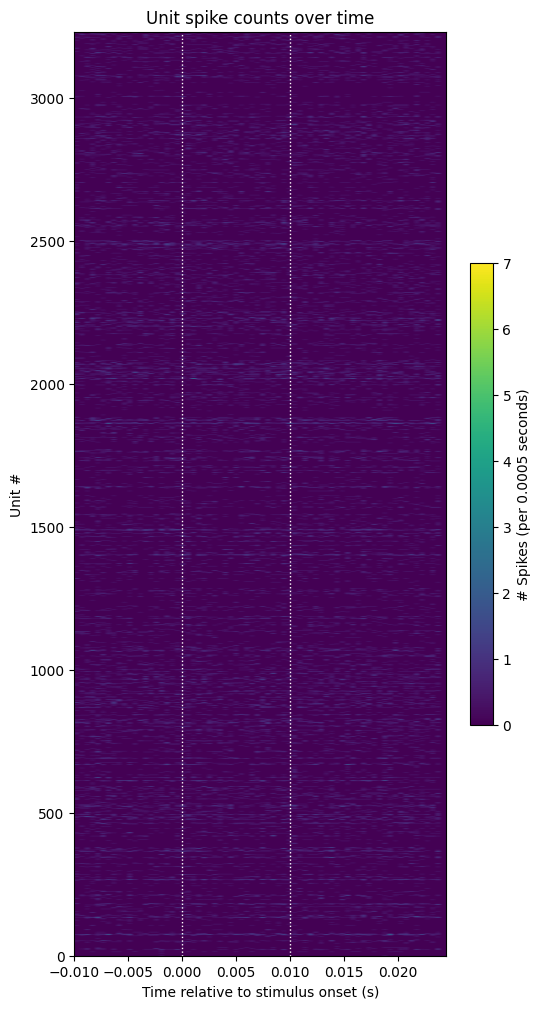

In [57]:
show_counts(spike_counts,
            stim_bounds=[0, stim_duration],
            title="Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)")